<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li>

# Проект для интернет-магазина «Викишоп»

**Проект:  Проект для интернет-магазина «Викишоп»**
_____
**Описание исследования.**
    
К нам обратился интернет-магазин «Викишоп», который запускает новый сервис для того, чтобы пользователи могли редактировать и дополнять описания товаров, как в вики-сообществах. Клиенты будут предлагать свои правки и комментировать изменения других. Заказчику нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
_____
**Цель исследования.**
    
Построить модель для оценки тональности текста для полной или частичной автоматизации модерации.
    
_____
**Задачи исследования.**

Для того, чтобы достичь поставленной цели необходимо решить ряд задач:

- подготовить данные, которые нам предоставил заказчик;
- провести анализ полученных данных (проверить данные на наличие ошибок, найти закономерности);
- построить модель, качество которой будет удовлетворять требованиям заказчика;
- протестировать полученную модель на тестовой выборке и сделать выводы.
_____
**Исходные данные.**
    
Заказчиком были переданы данные в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
#!pip install imbalanced-learn -q
#!pip install wordcloud
#!pip install swifter - q
#!pip install xgboost
#!pip install urlextract

In [2]:
import pandas as pd
from tqdm import notebook
import re
import torch
import swifter
import transformers
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from matplotlib.transforms import (Bbox, TransformedBbox,
                                   blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (BboxConnector,
                                                   BboxConnectorPatch,
                                                   BboxPatch)
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report
from __future__ import unicode_literals, print_function
from sklearn.feature_extraction.text import CountVectorizer
from urlextract import URLExtract

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\igor.grenaderov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\igor.grenaderov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
RANDOM_STATE = 88

## Подготовка

In [7]:
df = pd.read_csv('C:/Users/igor.grenaderov/datasets/toxic_comments.csv')

<font color='Blue'><b>Комментарий</b></font>

Импортировал данные `toxic_comments.csv` с исходными данными.

In [8]:
df.head()

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [9]:
df['toxic'].value_counts()

toxic
0    143106
1     16186
Name: count, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


<font color='Blue'><b>Комментарий</b></font>

Вывел информацию о полученном датафрейме: типы данных корректные, пропусков нет.


In [11]:
df.drop('Unnamed: 0', axis=1, inplace=True)

<font color='Blue'><b>Комментарий</b></font>

Удалил столбец `Unnamed: 0`.

In [12]:
df['text'].duplicated().sum()

0

<font color='Blue'><b>Комментарий</b></font>

Проверил, есть ли в данных явные дубликаты - явных дубликатов не обнаружил.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [14]:
def nl_split(string):
    
    string = re.split('\n+',string)
    result = [sent_tokenize(i.strip().rstrip('.')) for i in string]
    result = sum(result, [])
    
    return [i for i in result if len(i)>1]

<font color='Blue'><b>Комментарий</b></font>

Написал функцию для разделения строк на предложения.

In [15]:
df['sents_len'] = df['text'].swifter.apply(lambda x: len(nl_split(x)))

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

In [16]:
df['len'] = df['text'].swifter.apply(lambda x: len(x))

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

In [17]:
df['word_count'] = df['text'].swifter.apply(lambda x: len(word_tokenize(x)))

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

In [18]:
df['space_count'] = df['text'].swifter.apply(lambda x: x.count(' '))

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

<font color='Blue'><b>Комментарий</b></font>

Добавил столбцы с количеством предложений `sents_len`, с длинной текста `len`, количеством слов, которые встречаются в словаре nltk `word_count` и количеством слов, которые написали пользователи `space_count`.

In [19]:
def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = {
            **prop_lines,
            "alpha": prop_lines.get("alpha", 1) * 0.2,
            "clip_on": False,
        }

    c1 = BboxConnector(
        bbox1, bbox2, loc1=loc1a, loc2=loc2a, clip_on=False, **prop_lines)
    c2 = BboxConnector(
        bbox1, bbox2, loc1=loc1b, loc2=loc2b, clip_on=False, **prop_lines)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(bbox1, bbox2,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           clip_on=False,
                           **prop_patches)

    return c1, c2, bbox_patch1, bbox_patch2, p


def zoom_effect01(ax1, ax2, xmin, xmax, **kwargs):


    bbox = Bbox.from_extents(xmin, 0, xmax, 1)

    mybbox1 = TransformedBbox(bbox, ax1.get_xaxis_transform())
    mybbox2 = TransformedBbox(bbox, ax2.get_xaxis_transform())

    prop_patches = {**kwargs, "ec": "none", "alpha": 0.2}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2,
        loc1a=3, loc2a=2, loc1b=4, loc2b=1,
        prop_lines=kwargs, prop_patches=prop_patches)
    
    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)
    
    return c1, c2, bbox_patch1, bbox_patch2, p

In [20]:
def zoom_plt(df, x, label, hue, zoom_lim):
    
    axs = plt.figure(figsize=(10,7)).subplot_mosaic([
        ['zoom1'],
        ['main']
    ])

    for ax in axs:
        axs[ax]=sns.boxplot(data=df, x=x, hue=hue, ax=axs[ax], palette = ['#7bff5c',"#2456ff"])
        axs[ax].legend(['не токсичные комментарии', 'токсичные комментарии'])
        axs[ax].set_xlabel(label)
    
    zoom_effect01(axs['zoom1'], axs['main'], zoom_lim[0], zoom_lim[1])
    axs['zoom1'].set(xlim=zoom_lim)
    
    plt.suptitle(f'Ящик с усами значений колонки "{label}"')
    plt.show()

<font color='Blue'><b>Комментарий</b></font>

Написал функцию для построения диаграмм размаха, чтобы сравнить разброс и медианные значения количества слов, количества символов и количества предложений в не токсичных и токсичных предложениях.

In [21]:
name_dict = {
    'word_count' : ['количество словарных слов', (0,210)],
    'space_count': ['количество слов',(0,210)],
    'len' : ['количество символов',(0,1000)],
    'sents_len' : ['количество предложений',(0,15)]
}

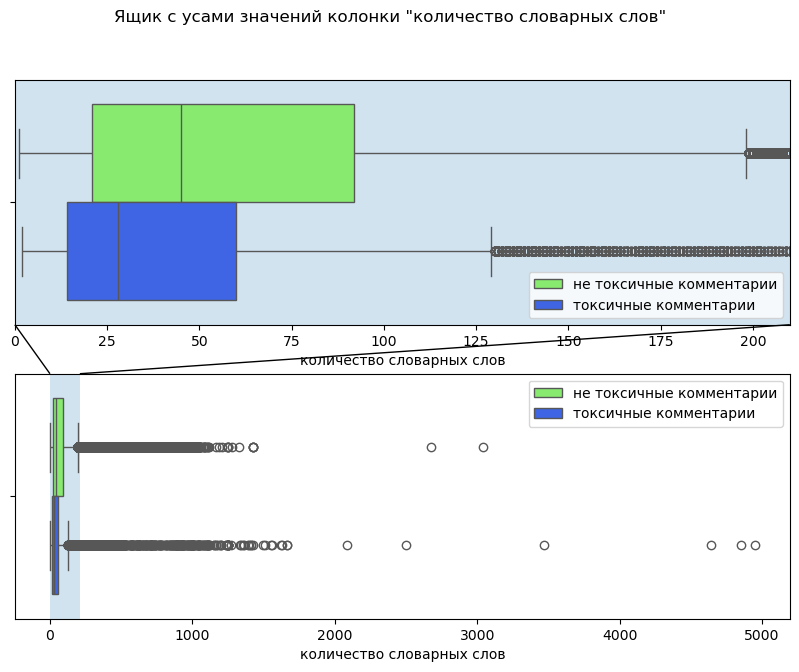

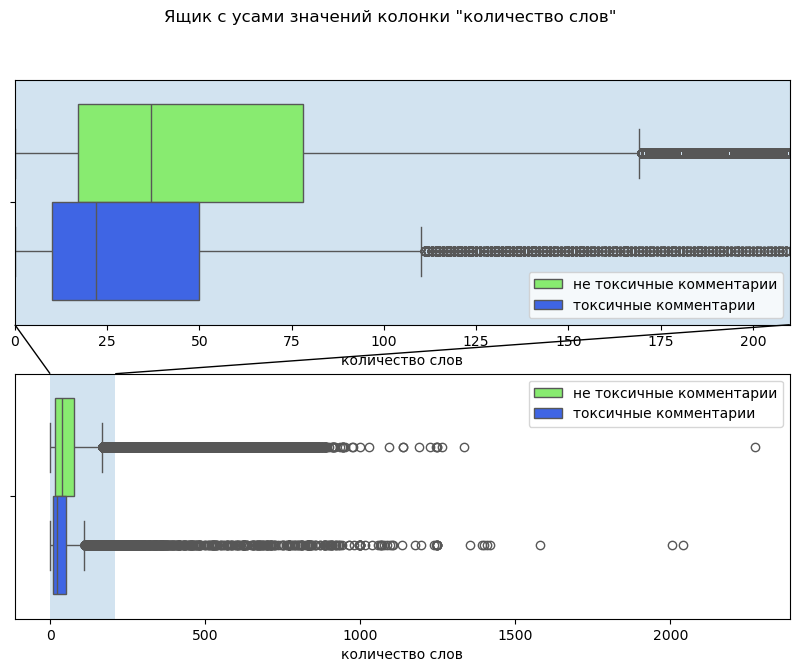

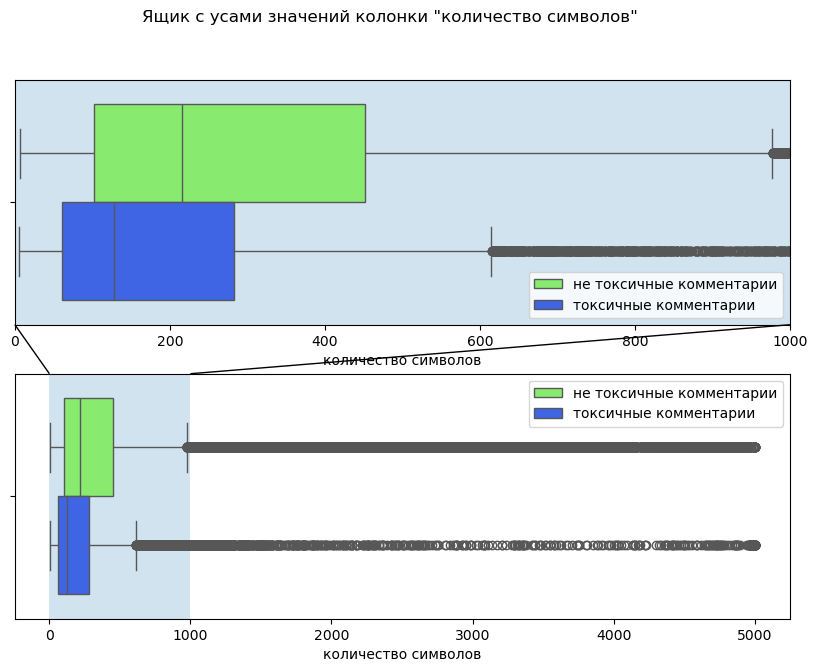

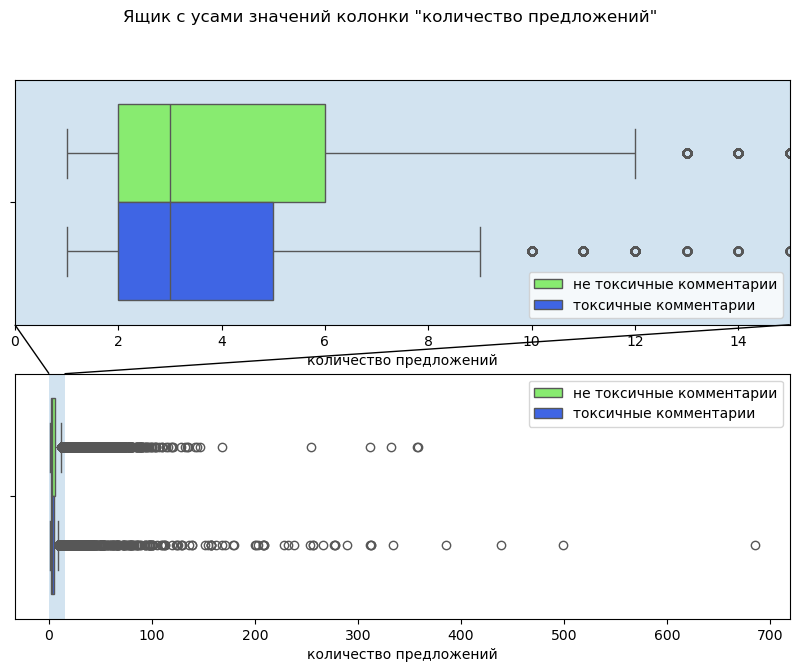

In [22]:
for t, y in name_dict.items():
    zoom_plt(df, t, y[0], 'toxic', y[1])

<font color='Blue'><b>Комментарий</b></font>

Построил диаграммы размаха для значений с количеством предложений, с длинной текста, количеством слов и количеством словарных слов, которые использовали пользователи в не токсичных и токсичных комментариях. 

Можно заметить, что аномально большие значения встречаются в обеих категориях комментариев, но не токсичные комментарии, как правило, содержат большее количество предложений, символов и слов.

In [23]:
def w_count(dataframe, df_cleaning=False, stop_words_filtered = False):

    if df_cleaning == True:
        dataframe = dataframe.str.lower()
        dataframe = dataframe.swifter.apply(lambda x: re.sub(r'\W', ' ', x))
        dataframe = dataframe.swifter.apply(lambda x: re.sub(r'\s+', ' ', x))
        
    word2count = {}
    
    for data in dataframe:
        words = nltk.word_tokenize(data)
        for word in words:
            if word not in word2count:
                word2count[word] = 1
            else:
                word2count[word] += 1

    if stop_words_filtered == True:
        stop_words = set(stopwords.words('english'))
        filtered_word2count = {word: count for word, count in word2count.items() if word not in stop_words}
        word_freq_df = pd.DataFrame(list(filtered_word2count.items()), columns=['word', 'frequency'])
        word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)
    else:
        filtered_word2count = {word: count for word, count in word2count.items()}
        word_freq_df = pd.DataFrame(list(filtered_word2count.items()), columns=['word', 'frequency'])
        word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

    return word_freq_df

<font color='Blue'><b>Комментарий</b></font>

Написал функцию для подсчета слов в датафрейме для того, чтобы можно было узнать, какие слова встераются чаще всего.


In [24]:
df_toxic = df[df['toxic']==1]['text']
df_non_toxic = df[df['toxic']==0]['text']

In [25]:
words_w_trash0 = w_count(
    df_non_toxic,
    df_cleaning=False)

In [26]:
words_w_trash1 = w_count(
    df_toxic,
    df_cleaning=False)

In [27]:
words_wo_trash0 = w_count(
    df_non_toxic,
    df_cleaning=True)

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

In [28]:
words_wo_trash1 = w_count(
    df_toxic,
    df_cleaning=True)

Pandas Apply:   0%|          | 0/16186 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/16186 [00:00<?, ?it/s]

In [29]:
words_wo0 = w_count(
    df_non_toxic,
    df_cleaning=True,
    stop_words_filtered = True)

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

In [30]:
words_wo1 = w_count(
    df_toxic,
    df_cleaning=True,
    stop_words_filtered=True)

Pandas Apply:   0%|          | 0/16186 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/16186 [00:00<?, ?it/s]

<font color='Blue'><b>Комментарий</b></font>

Составил несколько датафремов, которые отличаются наличием или отсутствием негативных комментариев, наличием стоп - слов и наличием символов.


In [31]:
def bars(df_list, stitle):
    
    len_ = len(df_list)
    palette = ['#7bff5c',"#2456ff"]
    titles = ['Не токсичные комментарии', 'Токсичные комментарии']
    
    fig, ax = plt.subplots(1, len_, figsize=(10,7))
    
    for i in range(len_):
        
        sns.barplot(data = df_list[i], x='frequency', y='word', color=palette[i], ax=ax[i])
        ax[i].set_ylabel('слова')
        ax[i].set_xlabel('количество слов')
        ax[i].set_title(titles[i])
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['left'].set_visible(False)
        
    fig.suptitle(stitle)

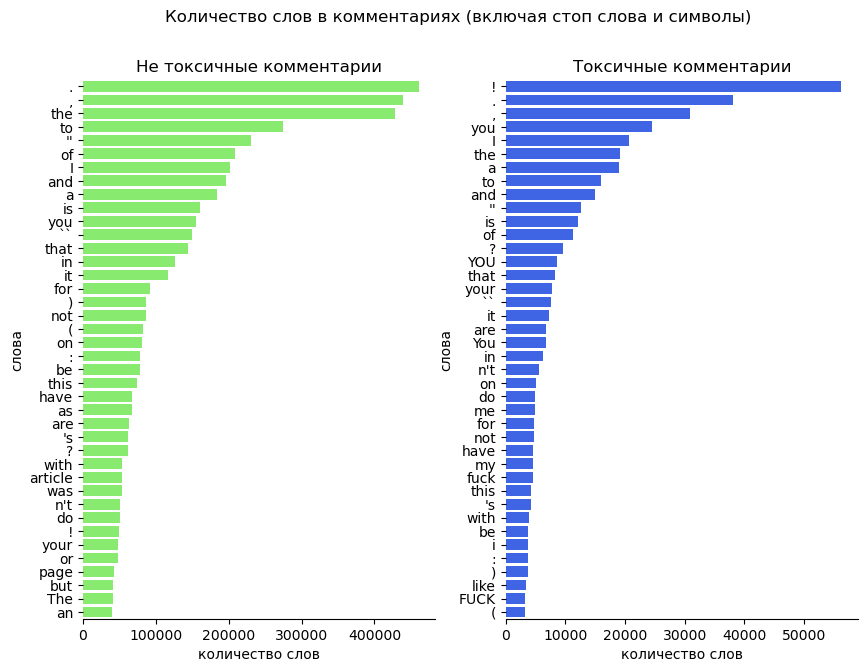

In [32]:
bars([
      words_w_trash0.head(40),
      words_w_trash1.head(40)], 
     'Количество слов в комментариях (включая стоп слова и символы)'
    )

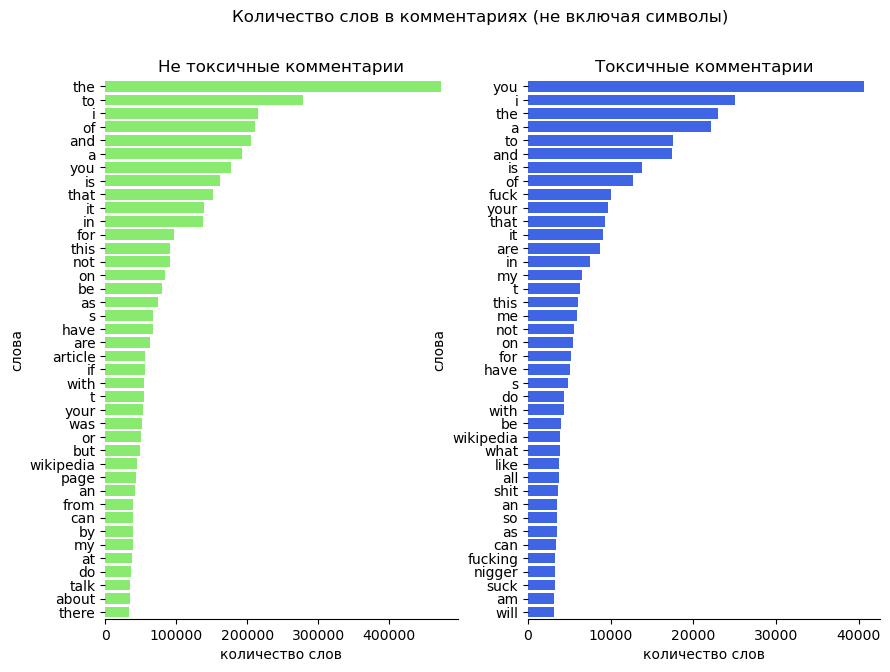

In [33]:
bars([words_wo_trash0.head(40),
      words_wo_trash1.head(40)], 
     'Количество слов в комментариях (не включая символы)'
    )

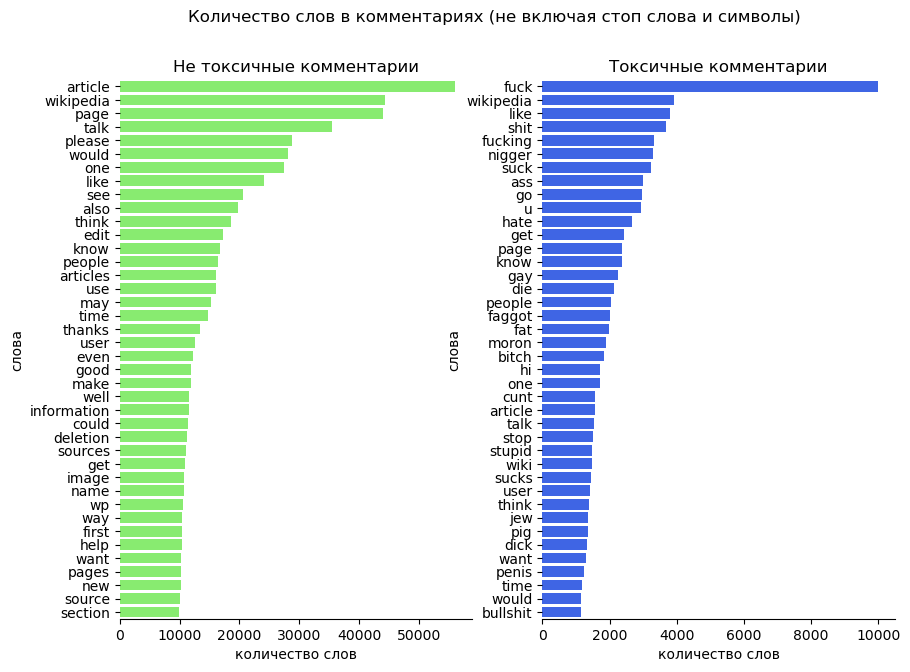

In [34]:
bars([words_wo0.head(40),
      words_wo1.head(40)],
     'Количество слов в комментариях (не включая стоп слова и символы)'
    )

<font color='Blue'><b>Комментарий</b></font>

Из столбчатых диаграмм, построенных выше видно, что в токсичных комментариях чаще встерчаются ругательства. Символы вроде скобок или восклицательных знаков встречаются в обеих категориях, как и стоп слова, а частота при этом разная, поэтому удалять их из текста при дальнейшей обработке стоит крайне осторожно.


In [35]:
words_w_trash0.tail(50)

,word,frequency
146582,soul-damning,1
146583,nation-destroying,1
146586,majoritarian,1
146590,dooms,1
146591,damns,1
146625,==Superscript,1
146627,rDNS,1
146628,RFC1912,1
146686,Fieryangel,1
146675,noze,1


In [36]:
words_w_trash1.tail(50)

,word,frequency
28032,Khar,1
28031,wch,1
28030,rheumatological/neurologica,1
3154,baklava,1
28028,freighted,1
28025,Ncrossman,1
28044,laser,1
28024,thimks,1
28023,86.45.211.71,1
28021,Rand,1


In [37]:
df[df['text'].str.contains('Birthday-cake-cake-cake')]

,text,toxic,sents_len,len,word_count,space_count
57666,"""\n\n Guessing you've heard it.... \n\nSo I wanna know if you want some Birthday-cake-cake-cake-cake-cake-cake-Birthday-cake-cake-cake-cake!? Because Imma make you my bitch tonight ;) Hehe (in all honesty, that song is beyond ridik) • Talk2Me """,1,3,242,43,35


In [38]:
df[df['text'].str.contains('f@ck', re.IGNORECASE)]

,text,toxic,sents_len,len,word_count,space_count
118152,Why is adrian such a f@cking loser??? GET A LIFE,1,2,48,15,9
145501,u think i get impressed by some f@ck!ng swedish @$$hole who has been on Wiki for 2 years? Hell no. Official press releases by Media outlets have been accepted for years now - and so will this one be.,1,3,199,49,38


<font color='Blue'><b>Комментарий</b></font>

Отобразил по 50 самых редко встретившихся слов в комментариях. Видно, что в строках могут встречаться ip адреса, url, слова, написанные с ошибками, или имена. 

При ближайшем рассмотрении можно встретить комментарии с большим количеством дубликатов внутри или с матными словами, которые замаскировали символами.

In [39]:
def url_rem(string_):
    extractor = URLExtract()
    urls = extractor.find_urls(string_)
    for url in urls:
        string_ = re.sub(re.escape(url), ' XXLNK ', string_)
    
    string_ = re.sub(r'https?://\S+|www\.\S+', ' XXLNK ', string_)
    string_ = re.sub(r'<.*?>+', ' XXLNK ', string_)
    return string_

In [40]:
def mail_user_rem(string_):
    
    string_ = re.sub(r'[A-Za-z0-9\_]*@[A-Za-z]*\.?[A-Za-z0-9]*', ' XXM ', string_)
    string_ = re.sub(r'User:\S+', ' XXU ', string_)

    return string_

In [41]:
def brackets(string, symbol, symbol1):

    '''symbol - [ or { ; symbol1 - ] or } '''
    
    patt = '\\' + symbol + '+' + '|' + '\\' + symbol1 + '+'
     
    string = re.sub('\n', '. ', string)

    
    braks = re.findall(patt, string)

    if len(braks)>1:

        
        
        if braks[0]==symbol1 or braks[0]==symbol1*2:
            patt1 = '\\' + symbol1 + '+'
            string =  re.split(patt1, string, maxsplit = 1)[::-1]+[symbol1]
                
            string = ' '.join(string)
        else:
            string = string
            
        
        sub_patt = '\\' + symbol + '+' + '.*' + '\\' + symbol1 + '+'

        result = re.sub(sub_patt, ' XXBRCT ', string)        
        if result==' XXBRCT ':
            result = string
    else:
        result = string


    
    return result

In [42]:
def clean_text(string):

    flag = re.IGNORECASE
    
    string = re.sub(r'\S+#\S+',' XXH ', string)
    string = re.sub(r'Image:\S+', ' XXF ', string, flags=flag)
    string = re.sub(r'File:\S+', ' XXF ', string, flags=flag)
    string = re.sub(r'Category:\S+',' XXC ',string, flags=flag)
    string = re.sub(r'Talk:\S+|User_talk:\S+',' XXW ',string, flags=flag)
    string = re.sub(r'Wikipedia.*:\S+',' XXW ',string, flags=flag)
    string = re.sub(r'\S+.png',' XXF ', string, flags=flag)
    string = re.sub(r'\S+.jpeg',' XXF ', string, flags=flag)
    string = re.sub(r'\S+.jpg',' XXF ', string, flags=flag)
    string = re.sub(r'\S+.gif',' XXF ', string, flags=flag)
    string = re.sub(r'\S+.pdf',' XXF ', string, flags=flag)
    string = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' XXIP ',string) 
    string = re.sub(r'(\W)\1+|(\D)\1+', r'\1', string)
    string = re.sub(r'[\_\+\~]', ' ', string)
    string = re.sub("[”‘’“«»]", r'"', string)
    string = re.sub("\t", r' ', string)
    string = re.sub("[A-Za-z0-9]+", lambda ele: " " + ele[0] + " ", string)
    string = re.sub(r'\s+', ' ', string)
    
    return string.strip()

In [43]:
def clean_sents(string):
    string = url_rem(string)
    string = brackets(string, '[',']')
    string = brackets(string, '{','}')
    sents = nl_split(string)
    
    cl_sents = [mail_user_rem(sent) for sent in sents]

    cl_sents = [clean_text(sent) for sent in cl_sents]
    return cl_sents

In [44]:
def chunker(string):

    sents_ = clean_sents(string)

    tokenized_sents = [tokenizer.encode(sent, add_special_tokens=False) for sent in sents_]

    usents=[]
   
    for sent in tokenized_sents:
        if sent not in usents:
            usents.append(sent)
    
    if len(usents)>1:
        result = [i+[102] for i in usents] 
        result = [101] + sum(result, [])
    
    elif len(usents)==1:
        result = [101] + usents[0] + [102]
    


    if len(set(result))/len(result)<0.02:
        result = [5567] + list(dict.fromkeys(result)) + [5567]
        
    if len(result)>512:

        result = result[:511] + [102]
    
    return result

<font color='Blue'><b>Комментарий</b></font>

Написал ряд функций, для того, чтобы отчистить текст и привести строки к общему виду:

* Удалил url;
* Удалил почтовые адреса;
* Удалил текст в квадратных и фугурных скоках;
* Удалил наименования категорий, файлов и пр.

Так же написал функцию, которая токенизирует текст и обрезает лист из токенов до необходимой длинны в 512 токенов.



In [45]:
tokenizer = transformers.BertTokenizer.from_pretrained('unitary/toxic-bert')

<font color='Blue'><b>Комментарий</b></font>

В качестве языковой модели выбрал toxicbert, так как он уже обучен на большом датасете с токсичными комментариями и поэтому должен хорошо подойти для формирования векторных представлений строк с комментариями.

In [46]:
def logy(feats, target):
    lr = LogisticRegression(random_state=RANDOM_STATE,max_iter=100000,class_weight='balanced')
    lr.fit(feats, target)
    scores = cross_val_score(lr, feats, target, cv=5, scoring='f1_macro')
    return scores

## Обучение

In [47]:
samp = df.sample(n=2000, random_state=RANDOM_STATE)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    samp['text'],
    samp['toxic'],
    test_size = 0.25,
    random_state = RANDOM_STATE,
    stratify = samp['toxic'])

In [49]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1500,), (500,), (1500,), (500,))

In [50]:
class BertTokenizer(object):

    def __init__(self, text, batch_size=1):
        
        self.text = text
        self.batch_size = batch_size
        self.model = transformers.BertModel.from_pretrained('unitary/toxic-bert')
        
        
    def get(self):
        
        tokenized = self.text.swifter.apply(lambda x: chunker(x))
        
        self.model.to(device)
        
        max_len = 0
        
        for tok in tokenized.values:
            if len(tok) > max_len:
                max_len = len(tok)

        padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
        attention_mask = np.where(padded != 0, 1, 0)
        
        batch_size = self.batch_size
        
        embeddings = []
        
        for i in notebook.tqdm(range(len(padded) // batch_size)):
                batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
                attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)
                
                with torch.no_grad():
                    batch_embeddings = self.model(batch, attention_mask=attention_mask_batch)
                
                embeddings.append(batch_embeddings[0][:,0,:].numpy())
    
        features = np.concatenate(embeddings)

        return features

In [51]:
dembs_train = BertTokenizer(text=X_train, batch_size=50).get()

Pandas Apply:   0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [52]:
logy(dembs_train, y_train.values)

array([0.9482598 , 0.9460367 , 0.93420847, 0.98030462, 0.95437817])

In [53]:
dembs_test = BertTokenizer(text=X_test,batch_size=50).get()

Pandas Apply:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [54]:
pipe = Pipeline([('models',[LogisticRegression(random_state=RANDOM_STATE,class_weight='balanced')])])

In [55]:
p_wei = y_train.value_counts()[0]/y_train.value_counts()[1]

In [56]:
param_grid = [

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, class_weight='balanced', verbose=2)],
        'models__solver': ['newton-cg', 'liblinear']
        
    },

    {
        'models': [XGBClassifier(
            random_state=RANDOM_STATE,
            eval_metric='logloss',
            verbosity=2,
            scale_pos_weight = p_wei,
            max_depth = 4)],
        'models__n_estimators' : [2000, 1500],
        'models__learning_rate' : [0.05, 0.1]
    }

]

In [57]:
grid_search = GridSearchCV(
    pipe, 
    param_grid, 
    cv=5,
    scoring='f1',
    verbose=2,
    n_jobs=-1
)
grid_search.fit(dembs_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\igor.grenaderov\AppData\Local\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[10:37:37] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (1500, 768, 1152000).


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('models',
                                        [LogisticRegression(class_weight='balanced',
                                                            random_state=88)])]),
             n_jobs=-1,
             param_grid=[{'models': [LogisticRegression(class_weight='balanced',
                                                        random_state=88,
                                                        verbose=2)],
                          'models__solver': ['newton-cg', 'liblinear']},
                         {'models': [XGBClassifier(base_score=None,
                                                   booster=None, callbacks=None,
                                                   colsample_byle...
                                                   learning_rate=None,
                                                   max_bin=None,
                                                   max_cat_threshold=None,
                                                   max_cat_to_onehot=None,
                                                   max_delta_step=None,
                                                   max_depth=4, max_leaves=None,
                                                   min_child_weight=None,
                                                   missing=nan,
                                                   monotone_constraints=None,
                                                   multi_strategy=None,
                                                   n_estimators=None,
                                                   n_jobs=None,
                                                   num_parallel_tree=None, ...)],
                          'models__learning_rate': [0.05, 0.1],
                          'models__n_estimators': [2000, 1500]}],
             scoring='f1', verbose=2)

<font color='Blue'><b>Комментарий</b></font>

После подбора модели при помощи gridsearch была найденна лучшая модель, ей оказалась `XGBClassifier` с lr 0.05, максимальной глубиной равной 4 и количесвтом эстимейторов равному 2000. 

In [58]:
grid_pred = grid_search.best_estimator_.predict(dembs_test)

In [59]:
f1_score(grid_pred, y_test)

0.9494949494949495

In [60]:
print(classification_report(grid_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       449
           1       0.98      0.92      0.95        51

    accuracy                           0.99       500
   macro avg       0.99      0.96      0.97       500
weighted avg       0.99      0.99      0.99       500



<font color='Blue'><b>Комментарий</b></font>

На тестовой выборке значение f1 метрики достигло почти `0.95`, что соответствует требованию заказчика.


## Выводы

<font color='Blue'><b>Комментарий</b></font>

В ходе проета были решены следующие задачи:


* подготовлены данные, которые нам предоставил заказчик;
* проведен анализ полученных данных;
* получена модель, качество которой соответствует требованию заказчика.
